In [4]:
import math
import os
import pickle
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import logging

from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import BCEWithLogitsLoss

from transformers.modeling_bert import BertEmbeddings, BertLayerNorm, BertModel, BertPreTrainedModel, gelu
from transformers import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report

from tqdm import tqdm, trange

In [3]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO,
                    filename='bert.log')
logger = logging.getLogger('bert.log')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

#### Helper functions to load/save the model

In [5]:
root_folder = '../bert'

def save_model(model, model_filename, folder=root_folder):
    ''' Save a pytorch model '''
    model_file = os.path.join(folder, model_filename)

    if os.path.exists(model_file):
        os.remove(model_file)

    # Save the model
    torch.save(model.state_dict(), model_file)

def load_model(folder, version):
    ''' Load a pytorch model '''
    config_filename = f'config_{version}.pkl'  

    with open(os.path.join(folder, config_filename), 'rb') as f:
        config = pickle.load(f)

    config.output_hidden_states = True
    model = BertForMultiLabelSequenceClassification(config)

    file = os.path.join(folder, f'bert_{version}_cuda.pt')
    state = torch.load(file) if is_cuda else torch.load(file, map_location=lambda storage, loc: storage)

    if is_cuda:
        model.cuda()

    return model

def remove_last_model(folder, model_filename, config_filename):
    model_file = os.path.join(folder, model_filename)

    if os.path.exists(model_file):
        os.remove(model_file)

    config_file = os.path.join(folder, config_filename)

    if os.path.exists(config_file):
        os.remove(config_file)

def file_exists(filename, folder=root_folder):
    return os.path.exists(os.path.join(folder, filename))

def save_object(filename, obj, folder=root_folder):
    obj_file = os.path.join(folder, filename)

    if os.path.exists(obj_file):
        os.remove(obj_file)

    with open(obj_file, 'wb') as f:
        pickle.dump(obj, f)

def load_object(filename, folder=root_folder):
    object_file = os.path.join(folder, filename)

    with open(object_file, 'rb') as f:
        return pickle.load(f)


#### BERT model creation

In [5]:
model_class = BertModel
tokenizer_class = BertTokenizer
pretrained_weights = 'bert-base-uncased'

In [6]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    """BERT model for multiple label classification."""
    def __init__(self, config):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        num_labels = len(label_columns)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob) # https://arxiv.org/abs/1207.0580
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        self.loss_fct = BCEWithLogitsLoss()

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        hidden, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None: 
            # Training the model                
            return self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
        
        else:
            return hidden, pooled_output, logits
            
        return loss

#### Input (text) processing

In [7]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample."""
        self.guid = guid
        self.text_a = text_a
        self.labels = labels

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

In [8]:
def convert_examples_to_features(examples, label_list, max_seq_length):
    """Loads a data file into a list of `InputBatch`s."""
    features = []
    count = 0
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

    for example in examples:
        tokens_a = tokenizer.tokenize(example.text_a)

        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding
        
        labels_ids = [float(label) for label in example.labels]
        features.append(InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=labels_ids))

    return features

In [9]:
# Load the full dataset into a DataFrame
df = pd.read_parquet('../data/nyt_full.parquet.gz')
SEED = 17
train, test = train_test_split(df, test_size=.2, random_state=SEED)

In [10]:
print(len(train.Id))
print(len(test.Id))

630802
157701


In [11]:
MAX_SEQ_LENGTH = 80
label_columns = [c for c in train.columns if c not in ['Id', 'Text']]

def get_labels(data, i):
    return data.iloc[i][label_columns]

def create_features(data, max_seq_length=MAX_SEQ_LENGTH):
    ''' Create the features for the BERT model '''
    
    print('Processing labels')
    #label_list = [get_labels(data, i) for i in range(len(data))]
    label_list = data[label_columns].values.tolist()
    print('Processing examples')
    examples = [InputExample(i, data.iloc[i].Text, labels=label_list[i]) for i in range(len(data))]
    print('Converting examples to features')

    return convert_examples_to_features(examples, label_list, max_seq_length)

def get_features(data, filename):
    ''' Create the features to the model '''
    if file_exists(filename):
        # Use the cached features if it exists
        features = load_object(filename)
    else:
        # Create and save the features
        features = create_features(data)
        save_object(filename, features)

    return features

train_features = get_features(train, 'train_bert_features.pkl')
test_features = get_features(test, 'test_bert_features.pkl')

#### DataLoader for PyTorch

In [29]:
batch_num = 32

def create_input_ids_tensor(data_features):
    return torch.tensor([i.input_ids for i in data_features])

def create_input_masks_tensor(data_features):
    return torch.tensor([i.input_mask for i in data_features])

def create_segment_ids_tensor(data_features):
    return torch.tensor([i.segment_ids for i in data_features])

def create_label_ids_tensor(data_features):
    return torch.tensor([i.label_ids for i in data_features])

def create_data_loader(data_features, batch_size=batch_num, drop_last=True, shuffle=True):
    dataset = TensorDataset(
      create_input_ids_tensor(data_features),
      create_input_masks_tensor(data_features),
      create_segment_ids_tensor(data_features),
      create_label_ids_tensor(data_features))
    sampler = RandomSampler(dataset)

    return DataLoader(dataset, sampler=sampler, batch_size=batch_size,drop_last=drop_last) if shuffle else DataLoader(dataset, batch_size=batch_size,drop_last=drop_last, shuffle=shuffle)

#### Training of the model

In [13]:
pretrained_weights = 'bert-base-uncased'
model = BertForMultiLabelSequenceClassification.from_pretrained(pretrained_weights, 
                                                                num_labels=len(train.columns) - 2)
model.cuda()

BertForMultiLabelSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [14]:
# Set epoch and grad max num
epochs = 5
max_grad_norm = .1

In [15]:
# Fine tune model all layer parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]
    
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 3e-05
    weight_decay: 0.0
    weight_decay_rate: 0.01

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 3e-05
    weight_decay: 0.0
    weight_decay_rate: 0.0
)

In [16]:
# Prepare the model for training
model.train()

BertForMultiLabelSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [17]:
train_losses = []
test_losses = []

def calculate_loss(model):
    ''' Calculate the loss on the test set for the model '''
    with torch.no_grad():
        total_loss = 0
        num_examples = 0

        for steps, batch in enumerate(create_data_loader(test_features)):
            batch = tuple(t.to(device) for t in batch)
            batch_input_ids, batch_input_masks, batch_segment_ids, batch_labels = batch
            loss = model(batch_input_ids, batch_segment_ids, batch_input_masks, batch_labels)
            total_loss += loss.item()
            num_examples += batch_input_ids.size(0)

        return total_loss / num_examples

In [18]:
# Main Training loop 
for epoch in trange(epochs,desc="Epoch"):
    tr_loss = 0
    num_examples, num_steps = 0, 0
    
    # Loop over the batches
    for step, batch in enumerate(create_data_loader(train_features)):
        logger.info(f'Starting step {step} from epoch {epoch}')
        
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        outputs = model(b_input_ids, b_segment_ids, b_input_masks, b_labels)
        loss = outputs
        
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        num_steps += 1
        num_examples += b_input_ids.size(0)
                
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        logger.info(f'Finished step {step}')
    
    # Accumulate the losses
    train_losses.append(tr_loss / num_examples)
    test_losses.append(calculate_loss(model))
    
    # Save the partial results
    save_object('train_losses_bert.pkl', train_losses)
    save_object('test_losses_bert.pkl', test_losses)
    
    # Display the losses for the epoch
    logger.info(f'Train loss: {train_losses[-1]}, test loss: {test_losses[-1]}') 
    print(f'Train loss: {train_losses[-1]}, test loss: {test_losses[-1]}')

Epoch:  20%|██        | 1/5 [5:37:17<22:29:11, 20237.81s/it]

Train loss: 0.0026705804975672553, test loss: 0.0023630357706809135


Epoch:  40%|████      | 2/5 [11:14:43<16:52:00, 20240.09s/it]

Train loss: 0.0020954368177045026, test loss: 0.0022941292710932535


Epoch:  60%|██████    | 3/5 [16:52:09<11:14:43, 20241.88s/it]

Train loss: 0.0017869392465160684, test loss: 0.002323190247547505


Epoch:  80%|████████  | 4/5 [22:29:36<5:37:23, 20243.39s/it] 

Train loss: 0.0015305038314823987, test loss: 0.0024752737428435146


Epoch: 100%|██████████| 5/5 [28:07:10<00:00, 20246.05s/it]  

Train loss: 0.0013094415359667542, test loss: 0.0026083999580203145


In [19]:
pd.DataFrame({'x':list(range(1, len(train_losses) + 1)), 'train':train_losses, 'test':test_losses}).plot(x='x')

In [21]:
def calculate_confusion_matrix(features, model, batch_size):
    ''' Calculate the confusion matrix for the labels of the model '''
    
    model.cuda()
    model.eval()
    torch.cuda.empty_cache()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(create_data_loader(features)):
            # add batch to gpu
            batch = tuple(t.to('cuda') for t in batch)
            b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids, b_segment_ids, b_input_masks)
            predictions.append((torch.sigmoid(raw_outputs[2]) > .5).cpu().numpy().astype(int))
            true_labels.append(b_labels.cpu().numpy().astype(int))

        true_labels = np.vstack(true_labels)[0:(batch_size * len(predictions)),]
        predictions = np.vstack(predictions)

        return (multilabel_confusion_matrix(true_labels, predictions),
                true_labels,
                predictions)
    
def print_pct_correct(features, model):
    tmp = calculate_confusion_matrix(features, model, 80)
    print(f'Percentage correct {((tmp[1] == tmp[2]).astype(int).sum(1) == 12).sum() / tmp[1].shape[0]}')    

In [21]:
tmp = calculate_confusion_matrix(train_features, model, 80)
print(f'Percentage correct {((tmp[1] == tmp[2]).astype(int).sum(1) == 12).sum() / tmp[1].shape[0]}')

Percentage correct 0.8731102881493507


In [22]:
tmp = calculate_confusion_matrix(test_features, model, 80)
print(f'Percentage correct {((tmp[1] == tmp[2]).astype(int).sum(1) == 12).sum() / tmp[1].shape[0]}')

Percentage correct 0.7533989448051948


In [63]:
# Save the trained model
torch.save(model, '../bert/bert.pt')

### Evaluation

In [6]:
def load_model(filename, folder=root_folder):
    ''' Load a saved model '''
    return torch.load(os.path.join(folder, filename))

def calculate_confusion_matrix(features, model, batch_size):
    ''' Calculate the confusion matrix from a trained model '''
    model.eval()
    torch.cuda.empty_cache()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(create_data_loader(features, batch_size, False, False)):
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
            
            logger.info(f'Step {step}')
            b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids, b_segment_ids, b_input_masks)
            predictions.append((torch.sigmoid(raw_outputs[2]) > .5).cpu().numpy().astype(int))
            true_labels.append(b_labels.cpu().numpy().astype(int))

        true_labels = np.vstack(true_labels)[0:(batch_size * len(predictions)),]
        predictions = np.vstack(predictions)

        return (multilabel_confusion_matrix(true_labels, predictions),
                true_labels,
                predictions)

def calculate_predictions(features, model, batch_size):
    ''' Calculate the prediction from a trained model '''
    
    if n_gpu != 0:
        model.cuda()
        torch.cuda.empty_cache()

    model.eval()
    result = None

    with torch.no_grad():
        for step, batch in enumerate(create_data_loader(features, batch_size, False, False)):
            logger.info(f'Step {step}')
            
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
                
            b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids, b_segment_ids, b_input_masks)
            predictions = torch.sigmoid(raw_outputs[2]).cpu()
            predictions = predictions.numpy()
            result = predictions if result is None else np.append(result, predictions, axis=0)
            
        return result

def get_label_columns(data_frame):
    ''' Return the columns with labels from the dataframe '''
    return [c for c in data_frame.columns if c not in ('Id', 'Text') and '_Pred' not in c]

def add_predictions(data_frame, features, model, batch_size):
    ''' Calculate and add the predicted values to the dataframe '''
    logits = calculate_predictions(features, model, batch_size)
    predictions = (logits > .5).astype(int)
    
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]

def add_predictions_to_dataframe(data_frame, predictions):
    ''' Add the model prediction to the dataframe '''
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]
        
class ModelResult:
    ''' Helper class used to make prediction from a trained model '''
    
    def __init__(self, data_frame, features, model, batch_size):
        confusion_matrix, labels, predictions = calculate_confusion_matrix(features, model, batch_size)
        self.confusion_matrix = confusion_matrix
        self.labels = labels
        self.predictions = predictions
        self.label_columns = get_label_columns(data_frame)
        
    def save(self, filename):
        ''' Save the model results (this object) to disk '''
        save_object(filename, self)
        
    def get_classification_report(self, output_dictionary):
        ''' Return the classification report from the model predictions '''
        return classification_report(self.labels, self.predictions, 
                                     target_names=self.label_columns, 
                                     output_dict=output_dictionary)
        
    def get_results_dataframe(self):
        ''' Create a summary dataframe with the results from the model '''
        report_dict = self.get_classification_report(True)
        label_columns = list(self.label_columns)
        label_columns.append('weighted avg')
        classification_results = pd.DataFrame({'Label':label_columns})
        classification_results['Precision'] = [report_dict[c]['precision'] for c in label_columns]
        classification_results['Recall'] = [report_dict[c]['recall'] for c in label_columns]
        classification_results['F1-Score'] = [report_dict[c]['f1-score'] for c in label_columns]
        classification_results['Support'] = [report_dict[c]['support'] for c in label_columns]
        classification_results.loc[classification_results['Label'] == 'weighted avg', 'Label'] = 'Weighted Average'
        
        return classification_results


In [31]:
# Load a saved model
model = load_model('bert.pt', '../bert')

# Evaluate the model on the test set
model_results = ModelResult(test, test_features, model, 100)

In [32]:
model_results.save('bert_result_test.pkl')

In [7]:
model_results_bert = load_object('bert_result_test.pkl')

In [34]:
add_predictions_to_dataframe(test, model_results.predictions)

/home/marceloblinder/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Display the evaluation results

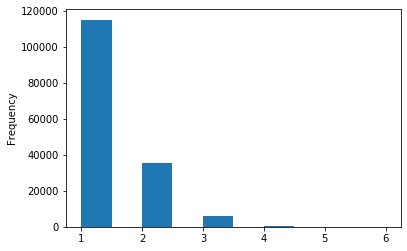

In [37]:
test[get_label_columns(test)].sum(1).plot.hist()

In [11]:
model_results.get_results_dataframe()

,Label,Precision,Recall,F1-Score,Support
0,World,0.869818,0.855948,0.862827,24144
1,Washington,0.726060,0.667735,0.695677,9050
2,New_York_and_Region,0.933312,0.885520,0.908788,35718
3,Front_Page,0.515350,0.477708,0.495816,5271
4,Business,0.966815,0.959684,0.963236,43382
5,US,0.753729,0.783843,0.768491,34040
6,Sports,0.978007,0.976957,0.977482,33546
7,Obituaries,0.973543,0.992539,0.982950,6970
8,Health,0.728869,0.685143,0.706330,7451
9,Education,0.708691,0.531519,0.607450,1396


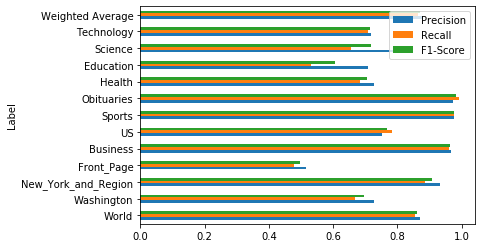

In [17]:
model_results.get_results_dataframe().plot.barh(x='Label', y=['Precision', 'Recall', 'F1-Score'])

#### Number of matches

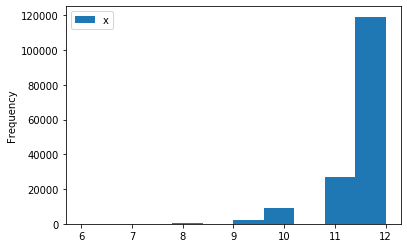

In [44]:
pd.DataFrame({'x':((model_results.labels == model_results.predictions).astype(int).sum(1))}).plot.hist()

In [25]:
tmp = calculate_confusion_matrix(test_features[0:1000], model, 80)
print(f'Percentage correct {((tmp[1] == tmp[2]).astype(int).sum(1) == 12).sum() / tmp[1].shape[0]}')

Percentage correct 0.7459677419354839


## Saving the model

* [pytorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

* [Google Drive](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=D78AM1fFt2ty)

## Bert

* [Bert Tutorial (Hidden Layers)](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)

* [GIT Huggingface](https://github.com/huggingface/transformers/blob/master/transformers/modeling_bert.py)